# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset **tanpa label** dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.
   
2. **Ketentuan Dataset**:
   - **Tanpa label**: Dataset tidak boleh memiliki label atau kelas.
   - **Jumlah Baris**: Minimal 1000 baris untuk memastikan dataset cukup besar untuk analisis yang bermakna.
   - **Tipe Data**: Harus mengandung data **kategorikal** dan **numerikal**.
     - *Kategorikal*: Misalnya jenis kelamin, kategori produk.
     - *Numerikal*: Misalnya usia, pendapatan, harga.

3. **Pembatasan**:  
   Dataset yang sudah digunakan dalam latihan clustering (seperti customer segmentation) tidak boleh digunakan.

Dataset ini dibuat untuk mensimulasikan pola penjualan yang realistis di industri minuman, menyoroti faktor-faktor penting seperti preferensi regional, fluktuasi musiman, dan segmentasi pelanggan. Dataset ini menampilkan transaksi Business-to-Business (B2B) dan Business-to-Consumer (B2C), sehingga dapat diadaptasi untuk berbagai tujuan analisis.

Kolom:
- Order_ID Pengidentifikasi unik untuk setiap pesanan. Mengelompokkan beberapa produk dalam pesanan yang sama.
- Customer_ID Pengidentifikasi unik untuk setiap pelanggan, yang membedakan pembeli individu.
- Jenis_Pelanggan Menunjukkan apakah pelanggan adalah B2B (bisnis-ke-bisnis) atau B2C (bisnis-ke-konsumen).
- Product Nama produk yang dibeli, seperti “Coca-Cola” atau “Erdinger Weißbier”.
- Kategori Kategori produk, seperti “Minuman Ringan” atau “Minuman Beralkohol”.
- Unit_Harga Harga per unit produk.
- Jumlah Jumlah unit yang dibeli untuk produk yang ditentukan dalam pesanan.
- Diskon Diskon yang diterapkan pada produk (misalnya, 0,1 untuk 10%). Diskon hanya diberikan kepada pelanggan B2B.
- Total_Harga Total harga untuk produk setelah menerapkan diskon.
- Wilayah Wilayah pelanggan, seperti “Bayern” atau “Berlin”.
- Tanggal_Pemesanan Tanggal ketika pesanan dilakukan.

Source: Kaggle

# **2. Import Library**

In [97]:
# Install RAPIDS libraries
# !pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 dask-cudf-cu12 cuml-cu12 cuxfilter-cu12 cucim
# !pip install cupy-cuda12x
# !pip install cuxfilter

In [47]:
import cudf
import cupy as cp
import cuml
import matplotlib.pyplot as plt
import seaborn as sns
from cuml.preprocessing import StandardScaler, RobustScaler
import cuxfilter as cxf
from cuml.metrics import pairwise_distances
from cuml.neighbors import NearestNeighbors
from cuml import UMAP, KMeans
from cuml.metrics.cluster import silhouette_score

# **3. Memuat Dataset**

In [48]:
# Load data
gdf = cudf.read_csv('/kaggle/input/beverage-sales/synthetic_beverage_sales_data.csv')

In [49]:
# Basic Data Overview
print("Data Shape:", gdf.shape)

Data Shape: (8999910, 11)


In [50]:
gdf.dtypes

Order_ID          object
Customer_ID       object
Customer_Type     object
Product           object
Category          object
Unit_Price       float64
Quantity           int64
Discount         float64
Total_Price      float64
Region            object
Order_Date        object
dtype: object

In [51]:
gdf.head()

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
0,ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
1,ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
2,ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
3,ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23
4,ORD1,CUS1496,B2B,Gerolsteiner,Water,0.87,35,0.10,27.40,Baden-Württemberg,2023-08-23


# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset. EDA bertujuan untuk:

1. **Memahami Struktur Data**
   - Tinjau jumlah baris dan kolom dalam dataset.  
   - Tinjau jenis data di setiap kolom (numerikal atau kategorikal).

2. **Menangani Data yang Hilang**  
   - Identifikasi dan analisis data yang hilang (*missing values*). Tentukan langkah-langkah yang diperlukan untuk menangani data yang hilang, seperti pengisian atau penghapusan data tersebut.

3. **Analisis Distribusi dan Korelasi**  
   - Analisis distribusi variabel numerik dengan statistik deskriptif dan visualisasi seperti histogram atau boxplot.  
   - Periksa hubungan antara variabel menggunakan matriks korelasi atau scatter plot.

4. **Visualisasi Data**  
   - Buat visualisasi dasar seperti grafik distribusi dan diagram batang untuk variabel kategorikal.  
   - Gunakan heatmap atau pairplot untuk menganalisis korelasi antar variabel.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

In [52]:
# Missing Value Analysis
missing_values = gdf.isnull().sum().to_pandas()
print("\nMissing Values:")
print(missing_values)


Missing Values:
Order_ID         0
Customer_ID      0
Customer_Type    0
Product          0
Category         0
Unit_Price       0
Quantity         0
Discount         0
Total_Price      0
Region           0
Order_Date       0
dtype: int64


In [53]:
# Basic Statistics
print("\nNumerical Columns Stats:")
print(gdf[['Unit_Price', 'Quantity', 'Discount', 'Total_Price']].describe().to_pandas())


Numerical Columns Stats:
         Unit_Price      Quantity      Discount   Total_Price
count  8.999910e+06  8.999910e+06  8.999910e+06  8.999910e+06
mean   5.818037e+00  2.313813e+01  2.972900e-02  1.307437e+02
std    1.470050e+01  2.689321e+01  4.479800e-02  5.096947e+02
min    3.200000e-01  1.000000e+00  0.000000e+00  3.000000e-01
25%    1.050000e+00  6.000000e+00  0.000000e+00  8.400000e+00
50%    1.750000e+00  1.100000e+01  0.000000e+00  2.114000e+01
75%    3.210000e+00  3.000000e+01  5.000000e-02  6.949000e+01
max    1.695300e+02  1.000000e+02  1.500000e-01  1.429530e+04


In [54]:
print("\nCategorical Columns Stats:")
print(gdf[['Customer_Type', 'Region', 'Category']].nunique())


Categorical Columns Stats:
Customer_Type     2
Region           16
Category          4
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


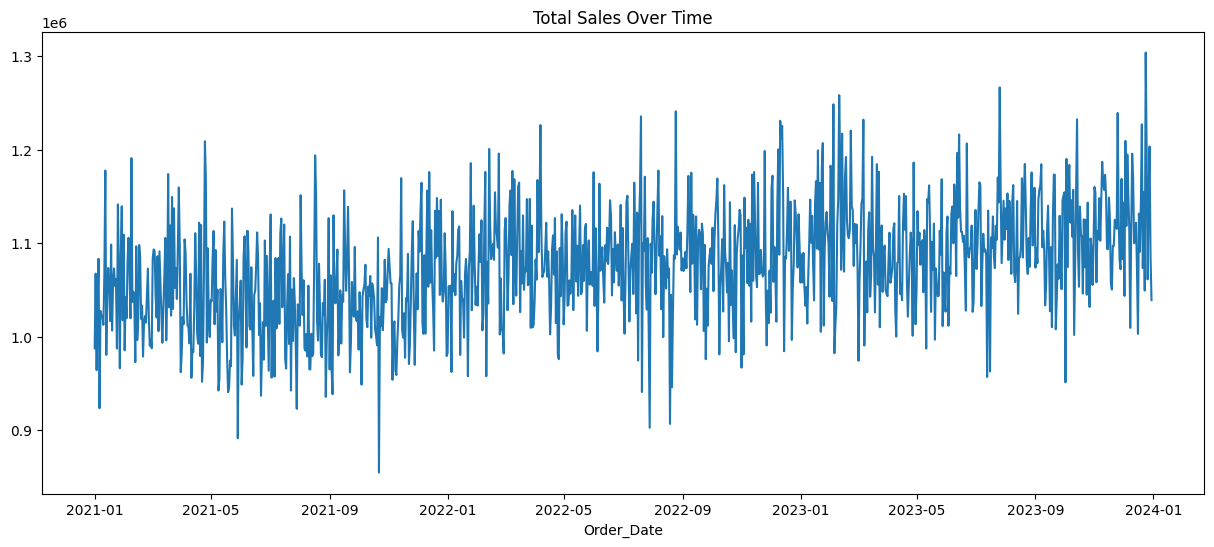

In [55]:
# Temporal Analysis (using GPU-accelerated operations)
gdf['Order_Date'] = cudf.to_datetime(gdf['Order_Date'])
gdf['Year'] = gdf['Order_Date'].dt.year
gdf['Month'] = gdf['Order_Date'].dt.month
gdf['Day'] = gdf['Order_Date'].dt.day

# Time Series Plot (convert to pandas for plotting)
plt.figure(figsize=(15, 6))
sales_over_time = gdf.groupby('Order_Date')['Total_Price'].sum().to_pandas()
sns.lineplot(x=sales_over_time.index, y=sales_over_time.values)
plt.title('Total Sales Over Time')
plt.show()

In [56]:
# Customer Analysis
customer_analysis = gdf.groupby('Customer_ID').agg({
    'Total_Price': 'sum',
    'Order_ID': 'nunique',
    'Discount': 'mean'
}).reset_index().rename(columns={
    'Total_Price': 'Total_Spent',
    'Order_ID': 'Order_Count',
    'Discount': 'Avg_Discount'
})

print("\nTop Customers by Spending:")
print(customer_analysis.sort_values('Total_Spent', ascending=False).head(5).to_pandas())


Top Customers by Spending:
     Customer_ID  Total_Spent  Order_Count  Avg_Discount
3186     CUS3866    367741.61          315      0.085700
1325     CUS2190    359547.51          309      0.087554
4581     CUS5120    356102.09          324      0.084343
8019     CUS8215    354744.41          317      0.083141
9159     CUS9241    353829.40          310      0.082727


In [57]:
# Regional Analysis
region_analysis = gdf.groupby('Region').agg({
    'Total_Price': 'sum',
    'Customer_ID': 'nunique',
    'Order_ID': 'nunique'
}).reset_index().rename(columns={
    'Total_Price': 'Total_Sales',
    'Customer_ID': 'Unique_Customers',
    'Order_ID': 'Total_Orders'
})

print("\nRegional Sales Performance:")
print(region_analysis.sort_values('Total_Sales', ascending=False).to_pandas())


Regional Sales Performance:
                    Region  Total_Sales  Unique_Customers  Total_Orders
5                  Hamburg  82470771.98               671        201457
6                   Hessen  78400110.19               608        182343
11                Saarland  78390587.15               636        191273
10         Rheinland-Pfalz  75838676.99               644        192687
7   Mecklenburg-Vorpommern  75517247.16               605        181637
15               Thüringen  75324865.47               626        187859
2                   Berlin  74567927.53               608        182569
1                   Bayern  72825399.18               617        185352
8            Niedersachsen  71959050.52               641        192298
12                 Sachsen  71946991.38               637        190813
0        Baden-Württemberg  71594838.90               613        184213
9      Nordrhein-Westfalen  71393803.70               632        189719
3              Brandenburg  7134903

In [58]:
#Product Analysis
product_analysis = gdf.groupby('Product').agg({
    'Quantity': 'sum',
    'Total_Price': 'sum',
    'Order_ID': 'nunique'
}).reset_index().rename(columns={
    'Quantity': 'Total_Units_Sold',
    'Total_Price': 'Total_Revenue',
    'Order_ID': 'Unique_Orders'
})

print("\nTop Selling Products:")
print(product_analysis.sort_values('Total_Units_Sold', ascending=False).head(10).to_pandas())



Top Selling Products:
                Product  Total_Units_Sold  Total_Revenue  Unique_Orders
15       Hohes C Orange           7794189    15048216.99         337114
40         Tomato Juice           7395329    19758646.12         318773
13        Granini Apple           7393212    12671649.17         319497
7       Cranberry Juice           7380841    23044830.98         319328
27  Passion Fruit Juice           7372320    22143146.68         318923
29   Rauch Multivitamin           7361875    18109425.51         318538
21          Mango Juice           7349108    22391933.19         317764
34       San Pellegrino           5934719     5188405.23         256068
43               Vittel           5921086     3791979.90         255790
0           Apollinaris           5770570     5137739.74         248642


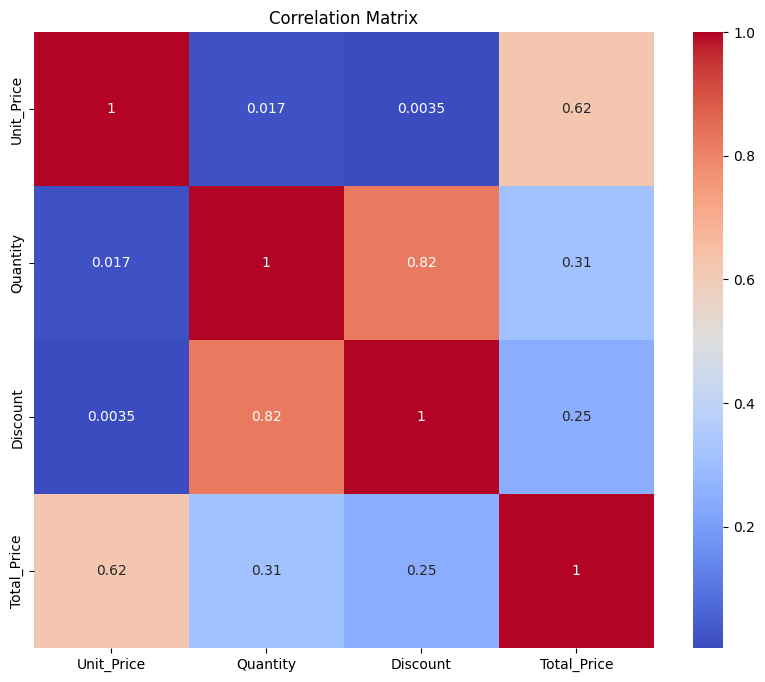

In [59]:
# Correlation Analysis
numerical_cols = ['Unit_Price', 'Quantity', 'Discount', 'Total_Price']
corr_matrix = gdf[numerical_cols].to_pandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning. Data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah.

In [60]:
# Customer-level aggregations
customer_df = gdf.groupby('Customer_ID').agg({
    'Total_Price': 'sum',
    'Order_ID': 'nunique',
    'Region': 'first',
    'Customer_Type': 'first'
}).rename(columns={
    'Total_Price': 'total_spending',
    'Order_ID': 'order_frequency'
}).reset_index()

In [61]:
# Menghitung presentase tiap kategori
category_pivots = gdf.groupby(['Customer_ID', 'Category'])['Total_Price'].sum().reset_index() 
category_pivots = category_pivots.pivot(index='Customer_ID', columns='Category', values='Total_Price').fillna(0) 

# Normalize to percentages
row_sums = category_pivots.sum(axis=1)
for col in category_pivots.columns:
    category_pivots[col] = category_pivots[col] / row_sums

category_percentages = category_pivots.add_suffix('_pct')

customer_df = customer_df.merge(category_percentages.reset_index(), on='Customer_ID', how='left')

In [62]:
# Calculate discount sensitivity for B2B customers
b2b_discounts = gdf[gdf['Customer_Type'] == 'B2B'].groupby('Customer_ID')['Discount'].mean().reset_index()
b2b_discounts = b2b_discounts.rename(columns={'Discount': 'discount_sensitivity'})
customer_df = customer_df.merge(b2b_discounts, on='Customer_ID', how='left')
customer_df['discount_sensitivity'] = customer_df['discount_sensitivity'].fillna(0)

In [63]:
# One-hot encode
customer_df = cudf.get_dummies(customer_df, columns=['Customer_Type'], drop_first=True)

In [64]:
# Scale numerical features
numerical_cols = ['total_spending', 'order_frequency']
# scaler = RobustScaler()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[numerical_cols])

customer_df[numerical_cols] = scaled_features

In [65]:
customer_df.head()

,Customer_ID,total_spending,order_frequency,Region,Alcoholic Beverages_pct,Juices_pct,Soft Drinks_pct,Water_pct,discount_sensitivity,Customer_Type_B2C
0,CUS9293,-0.753762,-1.796873,Bremen,0.804756,0.092382,0.066686,0.036176,0.0,True
1,CUS9294,-0.748921,-0.289818,Niedersachsen,0.744691,0.142344,0.071944,0.041021,0.0,True
2,CUS9295,-0.711272,-1.391127,Hamburg,0.809766,0.104237,0.053630,0.032366,0.0,True
3,CUS9296,-0.660474,0.637600,Hessen,0.812679,0.094151,0.054911,0.038259,0.0,True
4,CUS9297,-0.799500,-1.565018,Nordrhein-Westfalen,0.775824,0.114477,0.063377,0.046322,0.0,True


# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

Pada tahap ini, Anda membangun model clustering dengan memilih algoritma yang sesuai untuk mengelompokkan data berdasarkan kesamaan. Berikut adalah **rekomendasi** tahapannya.
1. Pilih algoritma clustering yang sesuai.
2. Latih model dengan data menggunakan algoritma tersebut.

### Model Selection

[2025-03-09 00:44:34.833] [CUML] [info] build_algo set to brute_force_knn because random_state is given


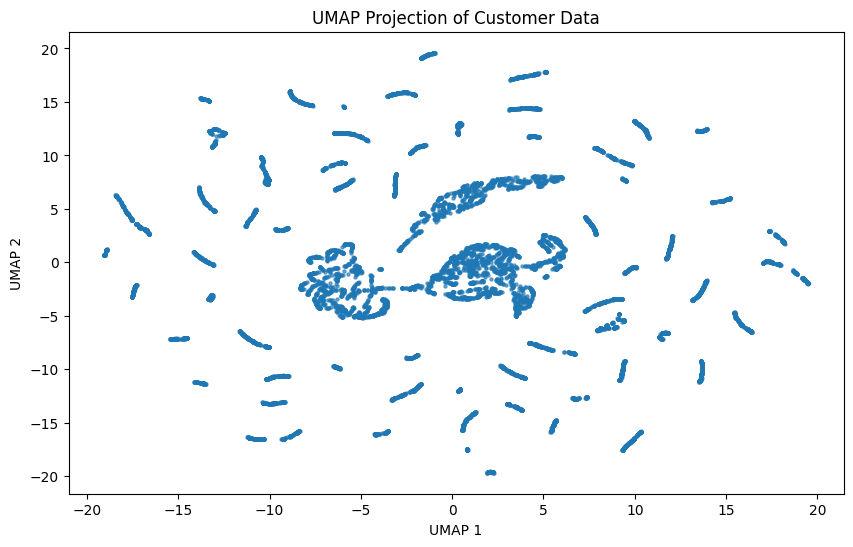

In [66]:
# Define features for UMAP for looking dataset regular or irregular
features_for_umap = customer_df.drop(columns=['Customer_ID', 'Region' ])

# Ensure features_for_umap is a cuDF DataFrame
if not isinstance(features_for_umap, cudf.DataFrame):
    features_for_umap = cudf.DataFrame(features_for_umap)

# Apply UMAP for 2D visualization
umap = UMAP(n_components=2, random_state=112)
embedding = umap.fit_transform(features_for_umap)

# If embedding is a cuDF DataFrame, convert it to a cuPy array
if isinstance(embedding, cudf.DataFrame):
    embedding = embedding.to_cupy()

# Convert cuPy array to NumPy array for plotting
embedding = embedding.get()  # This converts cuPy array to NumPy array

# Plot UMAP results
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.6)
plt.title("UMAP Projection of Customer Data")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

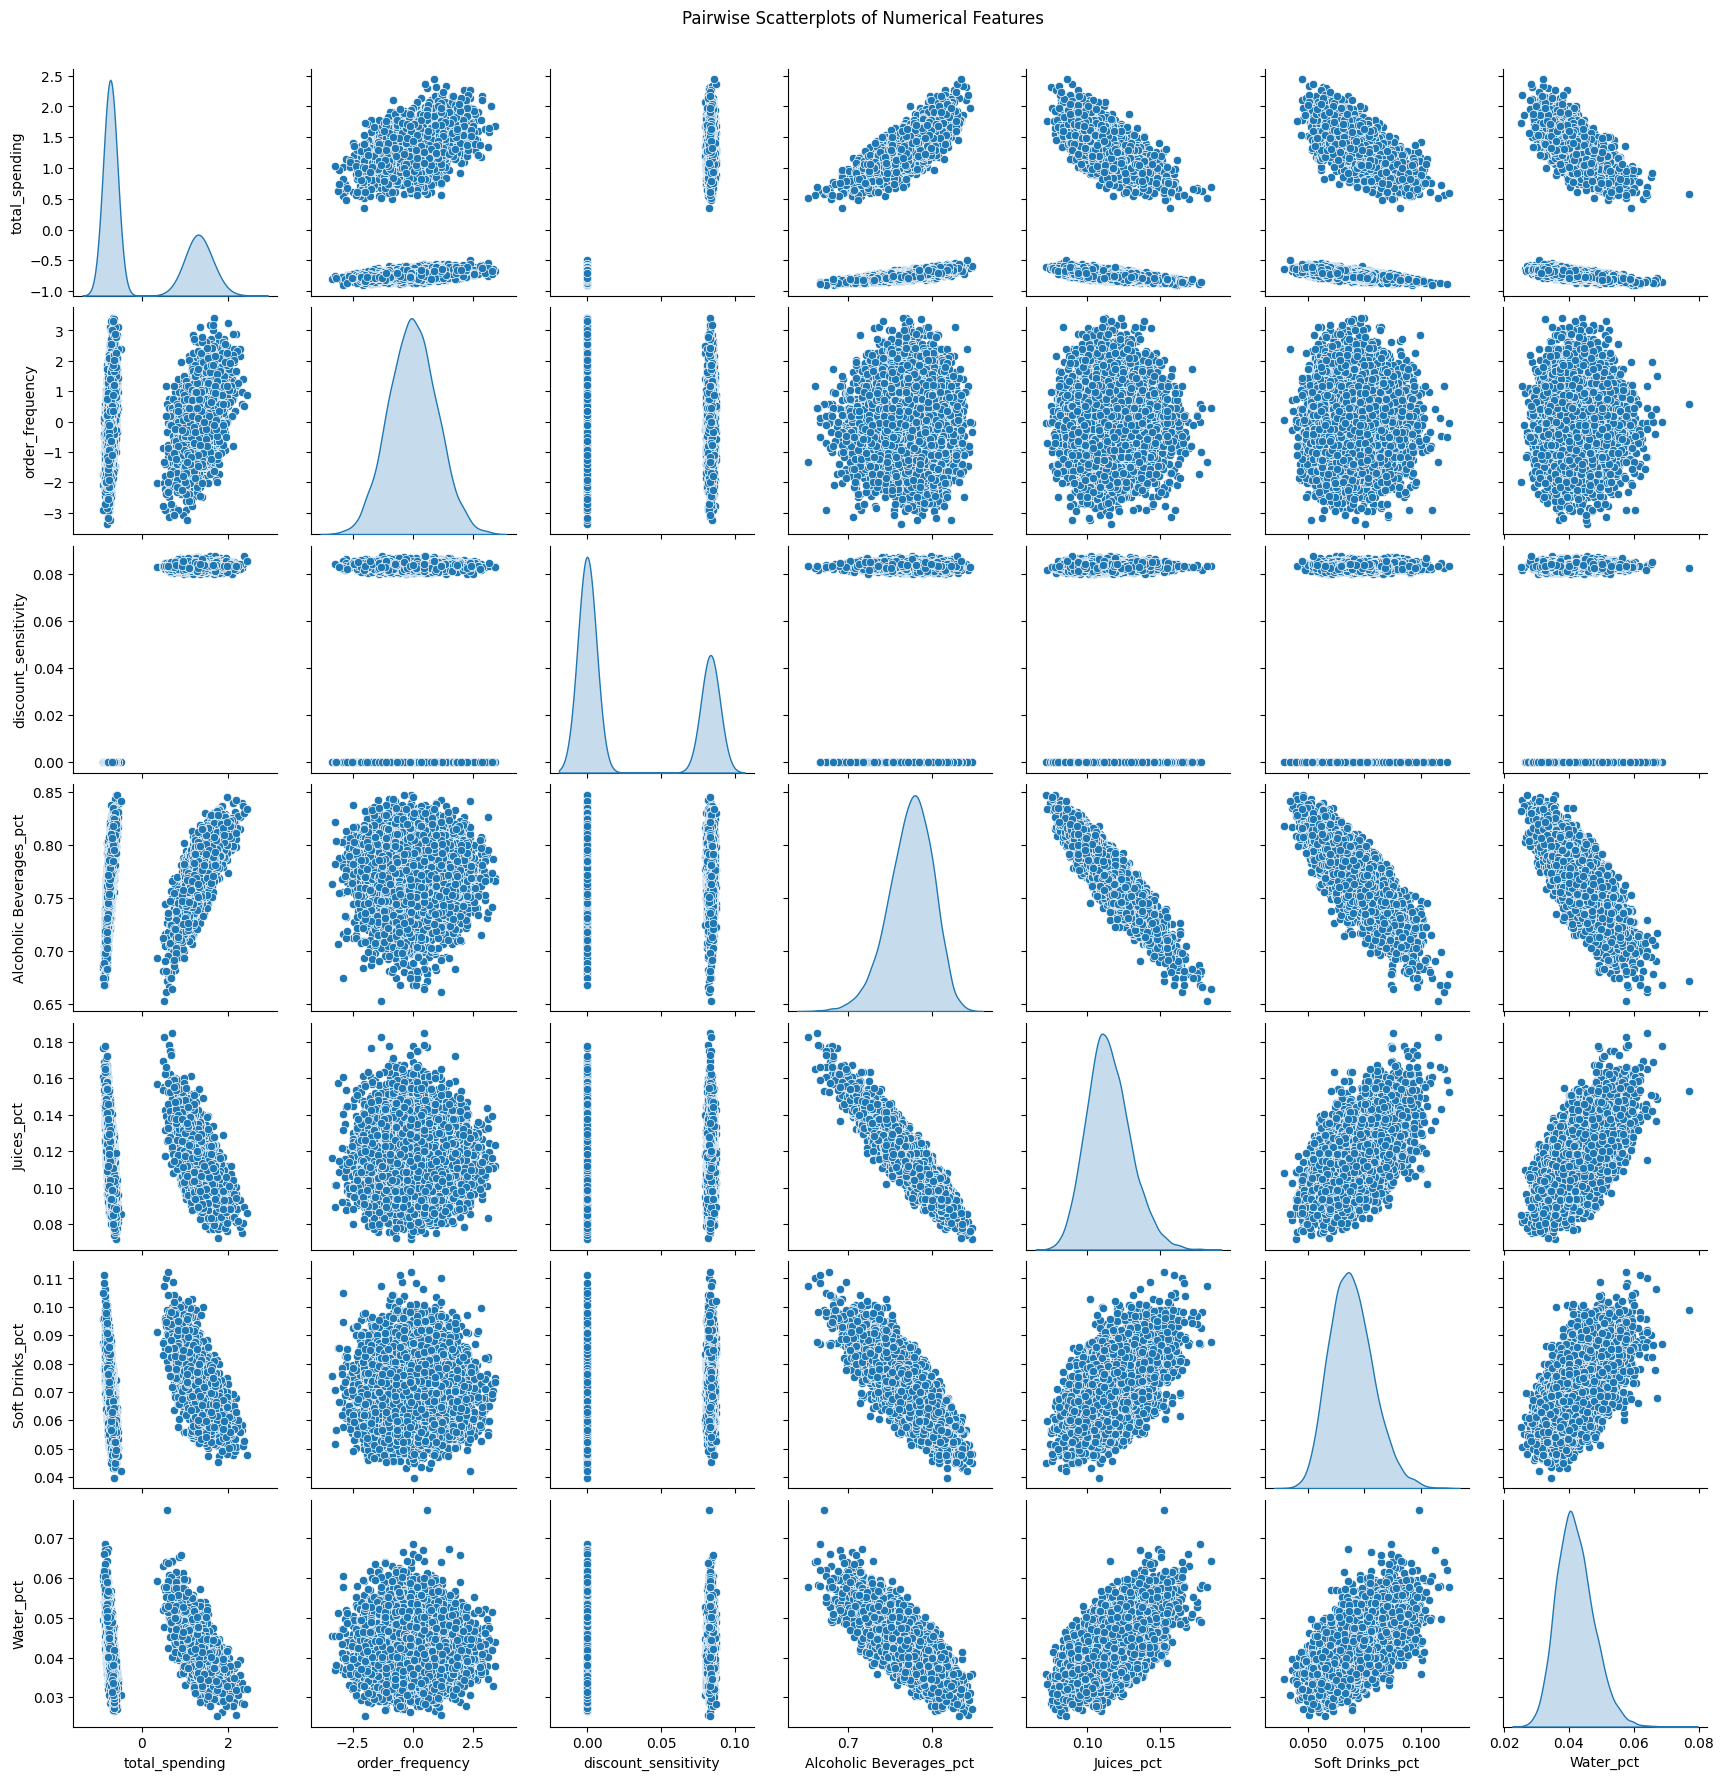

In [67]:
# Select numerical columns for pairwise scatterplots
numerical_cols = ['total_spending', 'order_frequency', 'discount_sensitivity', 'Alcoholic Beverages_pct', 'Juices_pct', 'Soft Drinks_pct', 'Water_pct']

# Create pairwise scatterplots
sns.pairplot(customer_df[numerical_cols].to_pandas(), diag_kind='kde')
plt.suptitle("Pairwise Scatterplots of Numerical Features", y=1.02)
plt.show()

Based on the UMAP projection in the image, the data appears to form distinct, spherical clusters. This suggests that the data is regular-shaped, making it suitable for centroid-based clustering algorithms like K-Means

### Modeling

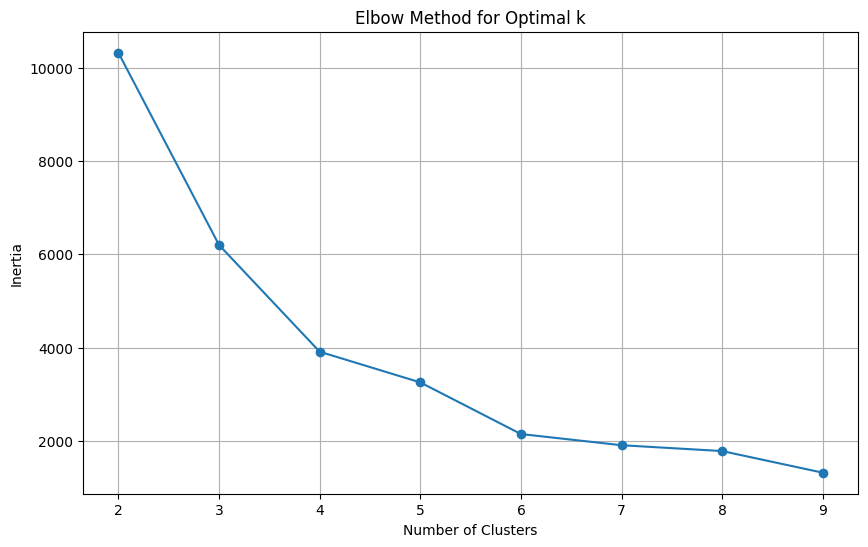

In [68]:
# Select features (!Customer_ID and categorical columns)
features = customer_df.drop(columns=['Customer_ID', 'Region'])

# Elbow Method
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=112)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [69]:
# K-Means
kmeans = KMeans(n_clusters=4, random_state=112)
labels = kmeans.fit_predict(features)

customer_df['Cluster'] = labels

## **b. Evaluasi Model Clustering**

Untuk menentukan jumlah cluster yang optimal dalam model clustering, Anda dapat menggunakan metode Elbow atau Silhouette Score.

Metode ini membantu kita menemukan jumlah cluster yang memberikan pemisahan terbaik antar kelompok data, sehingga model yang dibangun dapat lebih efektif. Berikut adalah **rekomendasi** tahapannya.
1. Gunakan Silhouette Score dan Elbow Method untuk menentukan jumlah cluster optimal.
2. Hitung Silhouette Score sebagai ukuran kualitas cluster.

In [70]:
# Silhouette Score
score = silhouette_score(features, labels)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.52


## **c. Feature Selection (Opsional)**

Silakan lakukan feature selection jika Anda membutuhkan optimasi model clustering. Jika Anda menerapkan proses ini, silakan lakukan pemodelan dan evaluasi kembali menggunakan kolom-kolom hasil feature selection. Terakhir, bandingkan hasil performa model sebelum dan sesudah menerapkan feature selection.

### Model 1

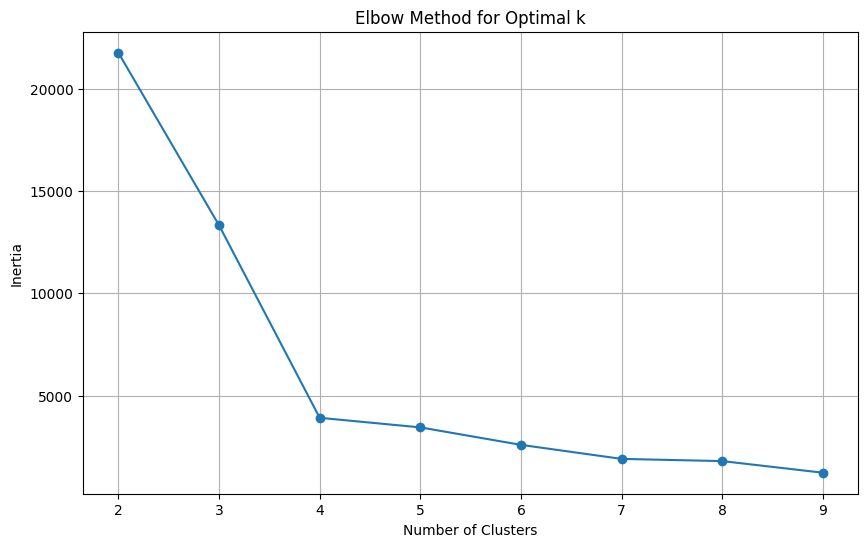

In [71]:
# Select features (!Customer_ID and categorical columns)
features = customer_df.drop(columns=['Customer_ID', 'Region', 'Customer_Type_B2C',])

# Elbow Method
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=112)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [72]:
# K-Means
kmeans = KMeans(n_clusters=4, random_state=112)
labels = kmeans.fit_predict(features)

customer_df['Cluster'] = labels

In [73]:
# Silhouette Score
score = silhouette_score(features, labels)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.67


### Model 2

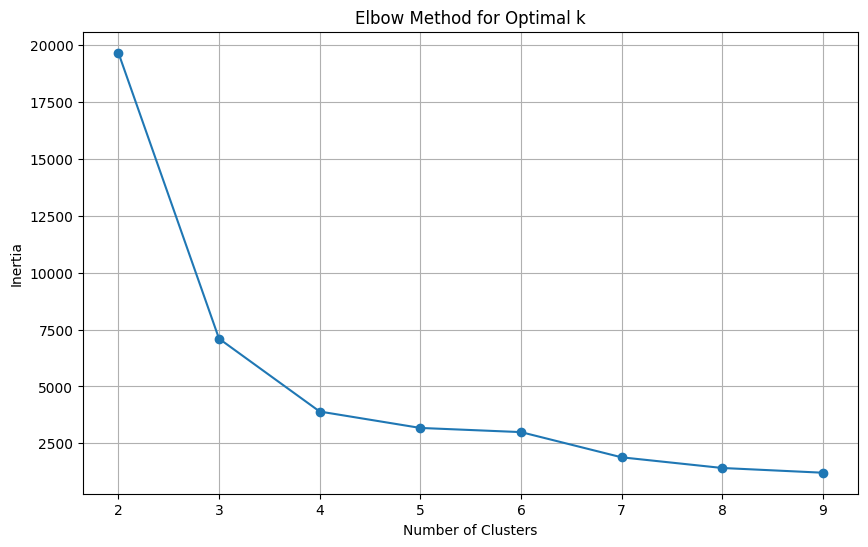

In [74]:
# Select features
features = customer_df.drop(columns=['Customer_ID', 'Region', 'Customer_Type_B2C', 'Alcoholic Beverages_pct', 'Juices_pct', 'Soft Drinks_pct', 'Water_pct'])

# Elbow Method
inertia = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=112)
    kmeans.fit(features)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [75]:
# K-Means
kmeans = KMeans(n_clusters=4, random_state=112)
labels = kmeans.fit_predict(features)

customer_df['Cluster'] = labels

In [76]:
# Silhouette Score
score = silhouette_score(features, labels)
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.70


## **d. Visualisasi Hasil Clustering**

Setelah model clustering dilatih dan jumlah cluster optimal ditentukan, langkah selanjutnya adalah menampilkan hasil clustering melalui visualisasi.

Berikut adalah **rekomendasi** tahapannya.
1. Tampilkan hasil clustering dalam bentuk visualisasi, seperti grafik scatter plot atau 2D PCA projection.

In [77]:
features = customer_df.drop(columns=['Customer_ID', 'Region', 'Customer_Type_B2C', 'Alcoholic Beverages_pct', 'Juices_pct', 'Soft Drinks_pct', 'Water_pct'])
kmeans = KMeans(n_clusters=4, random_state=112)
labels = kmeans.fit_predict(features)

customer_df['Cluster'] = labels

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Figure size 1500x1000 with 0 Axes>

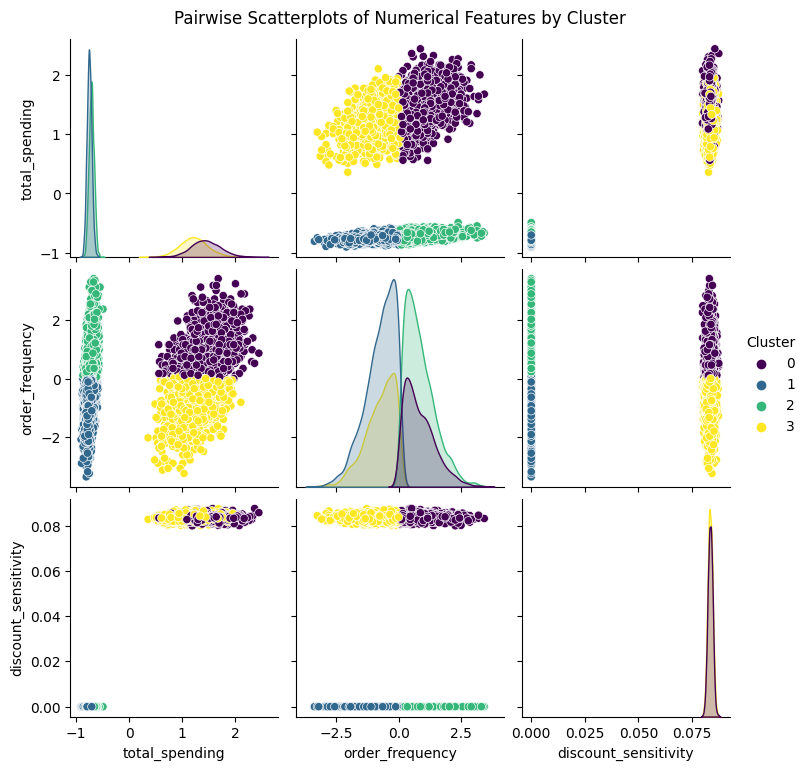

In [78]:
# Pairwise scatterplots
numerical_cols = ['total_spending', 'order_frequency', 'discount_sensitivity',]

# Create pairwise scatterplots
plt.figure(figsize=(15, 10))
sns.pairplot(customer_df[numerical_cols + ['Cluster']].to_pandas(), hue='Cluster', diag_kind='kde', palette='viridis')
plt.suptitle("Pairwise Scatterplots of Numerical Features by Cluster", y=1.02)
plt.show()

## **e. Analisis dan Interpretasi Hasil Cluster**

### Interpretasi Target

**Tutorial: Melakukan Inverse Transform pada Data Target Setelah Clustering**

Setelah melakukan clustering dengan model **KMeans**, kita perlu mengembalikan data yang telah diubah (normalisasi, standarisasi, atau label encoding) ke bentuk aslinya. Berikut adalah langkah-langkahnya.

---

**1. Tambahkan Hasil Label Cluster ke DataFrame**
Setelah mendapatkan hasil clustering, kita tambahkan label cluster ke dalam DataFrame yang telah dinormalisasi.

```python
df_normalized['Cluster'] = model_kmeans.labels_
```

Lakukan Inverse Transform pada feature yang sudah dilakukan Labelisasi dan Standararisasi. Berikut code untuk melakukannya:
label_encoder.inverse_transform(X_Selected[['Fitur']])

Lalu masukkan ke dalam kolom dataset asli atau membuat dataframe baru
```python
df_normalized['Fitur'] = label_encoder.inverse_transform(df_normalized[['Fitur']])
```
Masukkan Data yang Sudah Di-Inverse ke dalam Dataset Asli atau Buat DataFrame Baru
```python
df_original['Fitur'] = df_normalized['Fitur']
```

### Inverse Data Jika Melakukan Normalisasi/Standardisasi

Inverse Transform untuk Data yang Distandarisasi
Jika data numerik telah dinormalisasi menggunakan StandardScaler atau MinMaxScaler, kita bisa mengembalikannya ke skala asli:
```python
df_normalized[['Fitur_Numerik']] = scaler.inverse_transform(df_normalized[['Fitur_Numerik']])
```

In [79]:
numerical_cols = ['total_spending', 'order_frequency']

# Inverse the scaling
original_features = scaler.inverse_transform(customer_df[numerical_cols])

customer_df[numerical_cols] = original_features

print("Original Data:")
print(customer_df[numerical_cols].head())

Original Data:
   total_spending  order_frequency
0        40508.50            269.0
1        41004.07            295.0
2        44858.02            276.0
3        50058.01            311.0
4        35826.45            273.0


In [80]:
customer_df.head()

,Customer_ID,total_spending,order_frequency,Region,Alcoholic Beverages_pct,Juices_pct,Soft Drinks_pct,Water_pct,discount_sensitivity,Customer_Type_B2C,Cluster
0,CUS9293,40508.50,269.0,Bremen,0.804756,0.092382,0.066686,0.036176,0.0,True,1
1,CUS9294,41004.07,295.0,Niedersachsen,0.744691,0.142344,0.071944,0.041021,0.0,True,1
2,CUS9295,44858.02,276.0,Hamburg,0.809766,0.104237,0.053630,0.032366,0.0,True,1
3,CUS9296,50058.01,311.0,Hessen,0.812679,0.094151,0.054911,0.038259,0.0,True,2
4,CUS9297,35826.45,273.0,Nordrhein-Westfalen,0.775824,0.114477,0.063377,0.046322,0.0,True,1


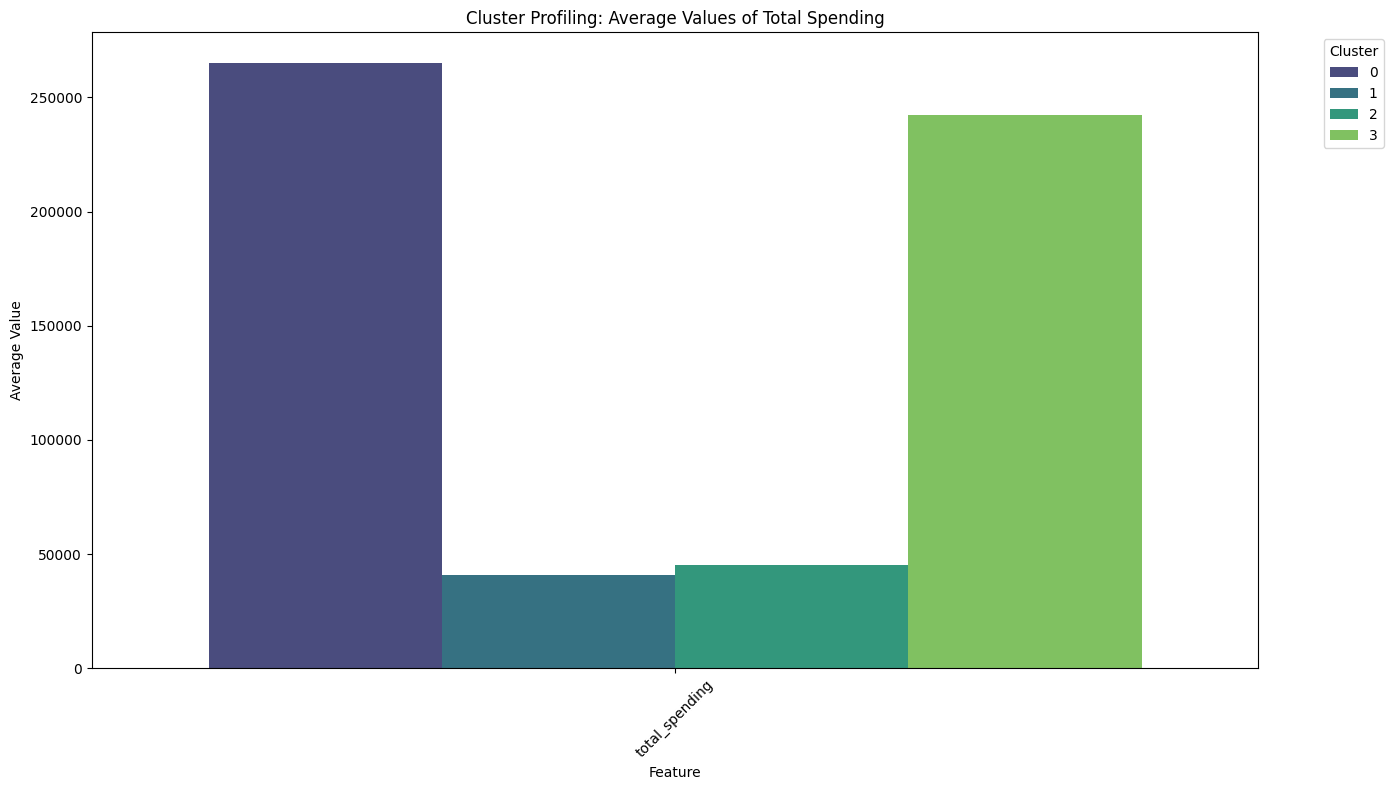

In [81]:
# Select only numeric columns for aggregation
numeric_cols = customer_df.select_dtypes(include=['float64', 'int64']).columns

# Group by cluster and calculate mean values for numeric columns
cluster_summary = customer_df.groupby('Cluster')[numeric_cols].mean()
cluster_summary = cluster_summary.reset_index()

features_to_plot = ['total_spending']

# Melt the DataFrame for easier plotting
cluster_summary_melted = cluster_summary.melt(id_vars='Cluster', value_vars=features_to_plot, var_name='Feature', value_name='Average Value')
cluster_summary_melted = cluster_summary_melted.to_pandas()

# Plot bar plots
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_summary_melted, x='Feature', y='Average Value', hue='Cluster', palette='viridis')
plt.title("Cluster Profiling: Average Values of Total Spending")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

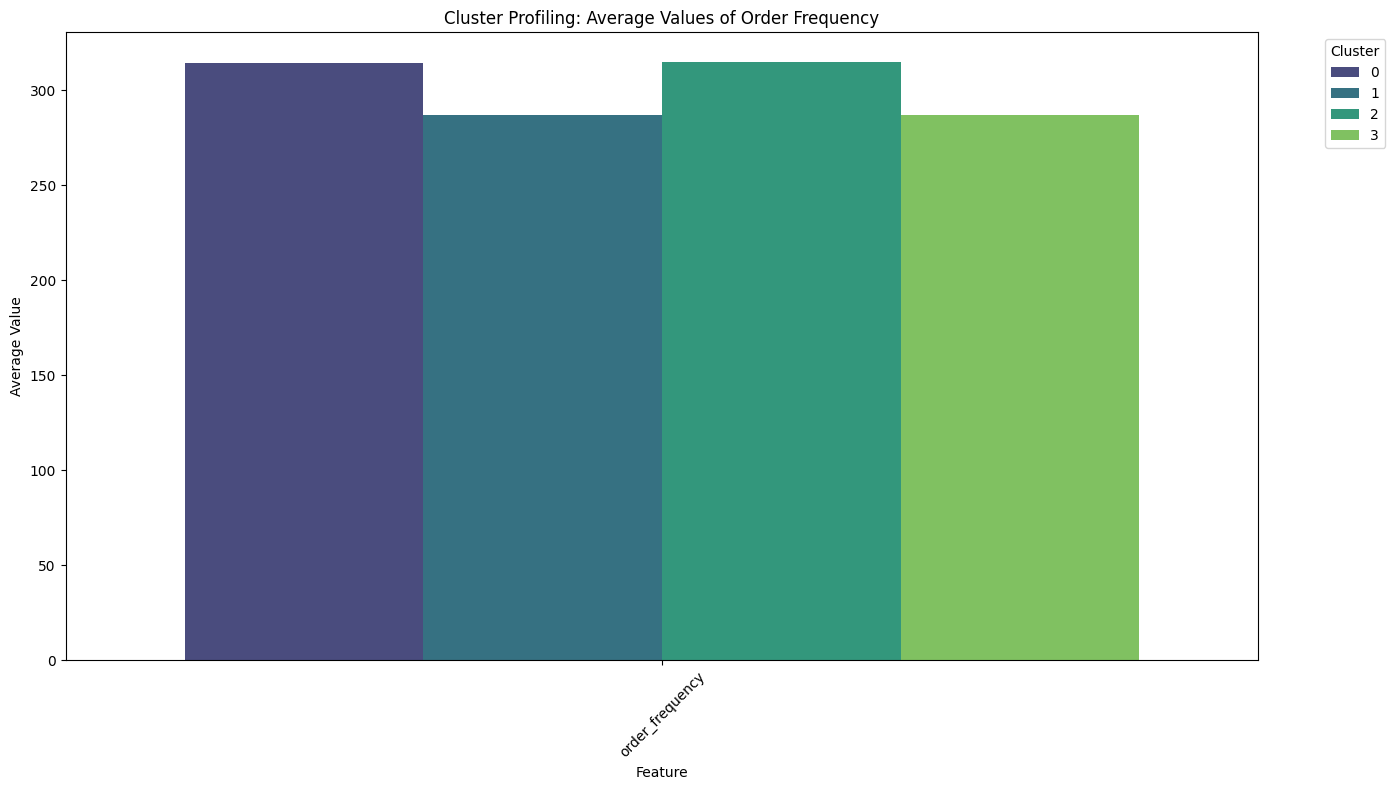

In [82]:
features_to_plot = ['order_frequency', ]

# Melt the DataFrame for easier plotting
cluster_summary_melted = cluster_summary.melt(id_vars='Cluster', value_vars=features_to_plot, var_name='Feature', value_name='Average Value')
cluster_summary_melted = cluster_summary_melted.to_pandas()

# Plot bar plots for each feature
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_summary_melted, x='Feature', y='Average Value', hue='Cluster', palette='viridis')
plt.title("Cluster Profiling: Average Values of Order Frequency")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

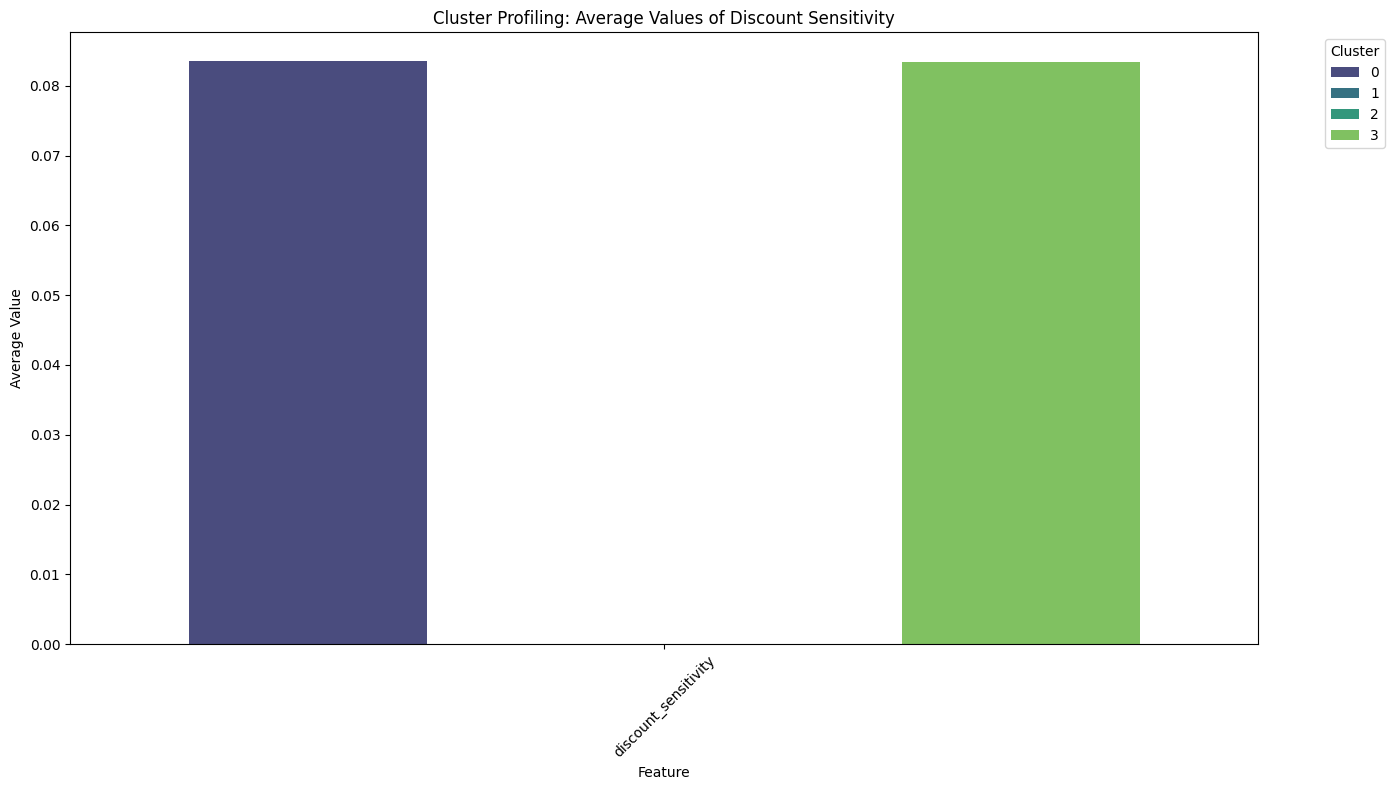

In [83]:
features_to_plot = ['discount_sensitivity', ]

# Melt the DataFrame for easier plotting
cluster_summary_melted = cluster_summary.melt(id_vars='Cluster', value_vars=features_to_plot, var_name='Feature', value_name='Average Value')
cluster_summary_melted = cluster_summary_melted.to_pandas()

# Plot bar plots for each feature
plt.figure(figsize=(14, 8))
sns.barplot(data=cluster_summary_melted, x='Feature', y='Average Value', hue='Cluster', palette='viridis')
plt.title("Cluster Profiling: Average Values of Discount Sensitivity")
plt.xlabel("Feature")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [111]:
cluster_analysis = (
    customer_df.to_pandas()
    .groupby("Cluster")
    .agg(
        # Aggregasi untuk fitur numerik
        total_spending_max=("total_spending", "max"),
        order_frequency_max=("order_frequency", "max"),
        discount_sensitivity_max=("discount_sensitivity", "max"),
        total_spending_mean=("total_spending", "mean"),
        order_frequency_mean=("order_frequency", "mean"),
        discount_sensitivity_mean=("discount_sensitivity", "mean"),
        total_spending_min=("total_spending", "min"),
        order_frequency_min=("order_frequency", "min"),
        discount_sensitivity_min=("discount_sensitivity", "min"),
        # Aggregasi untuk kategori (ambil modus)
        Region=("Region", lambda x: x.mode()[0]),
        Customer_Type=("Customer_Type_B2C", lambda x: "B2C" if x.mode()[0] else "B2B")
    )
    .reset_index()
)

table_df = cluster_analysis.set_index("Cluster").T.rename_axis("Feature").reset_index()
table_df


Cluster,Feature,0,1,2,3
0,total_spending_max,367741.61,57992.35,67424.96,333145.39
1,order_frequency_max,359.0,301.0,359.0,302.0
2,discount_sensitivity_max,0.087554,0.0,0.0,0.087428
3,total_spending_mean,265240.34279,40743.316153,44986.295265,242076.753941
4,order_frequency_mean,314.478673,287.079801,314.685676,286.916267
5,discount_sensitivity_mean,0.083497,0.0,0.0,0.08349
6,total_spending_min,174834.24,25127.18,28722.42,154343.58
7,order_frequency_min,300.0,242.0,301.0,244.0
8,discount_sensitivity_min,0.079892,0.0,0.0,0.079989
9,Region,Mecklenburg-Vorpommern,Rheinland-Pfalz,Sachsen,Thüringen


Tulis hasil interpretasinya di sini.
1. Cluster 0: **High spending, high frequency, discount.**
2. Cluster 1: **Low spending, no discount.**
3. Cluster 2: **High frequency,B2C , low spending.**
4. CLuster 3: **High spending, lower frequency, discount.**

# Contoh interpretasi [TEMPLATE]

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## **Cluster 0:**

1. **Average Total Spending**: $265,240
2. **Average Order Frequency**: 314
3. **Average Discount Sensitivity**: 8.3%
4. **Min Total Spending**: $174,834
5. **Min Order Frequency**: 300
6. **Min Discount Sensitivity**: 7.9%
7. **Max Total Spending**: $367.741
8. **Max Order Frequency**: 359
9. **Max Discount Sensitivity**: 8.7%
10. **Customer Category**: B2B
11. **Region Mode**: Mecklenburg-Vorpommern
12. **Analysis**: Cluster yang mencakup pelanggan B2B dengan pengeluaran tinggi dengan rata-rata $265,240 dan frekuensi yang intens dikisaran rata-rata 314 sehingga menjadikannya cluster B2B tier tertinggi. Sensitif terhadap diskon yang mungkin akan mempengaruhi kuantitas. Manfaatkan diskon secara strategis untuk mencegah kehilangan pelanggan dan tetap memantau keuntungan.

## **Cluster 1:**

1. **Average Total Spending**: $40,743
2. **Average Order Frequency**: 287
3. **Average Discount Sensitivity**: 0%
4. **Min Total Spending**: $25,127
5. **Min Order Frequency**: 242
6. **Min Discount Sensitivity**: 0%
7. **Max Total Spending**: $57,992
8. **Max Order Frequency**: 301
9. **Max Discount Sensitivity**: 0%
10. **Customer Category**: B2C
11. **Region Mode**: Rheinland-Pfalz
12. **Analysis**: CLuster ini mencakup pelanggan B2C dengan pengeluaran rendah dengan rata-rata $40,743 dan tidak responsif terhadap diskon karena B2C tidak mendapatkan diskon. Pada cluster ini dapat diberikan percobaan program diskon untuk mencoba meningkatkan frekuensi pembelian yang tergolong rendah di angka rata-rata 287.

## **Cluster 2:**

1. **Average Total Spending**: $44,986
2. **Average Order Frequency**: 314
3. **Average Discount Sensitivity**: 0%
4. **Min Total Spending**: $28,722
5. **Min Order Frequency**: 301
6. **Min Discount Sensitivity**: 0%
7. **Max Total Spending**: $67,424
8. **Max Order Frequency**: 359
9. **Max Discount Sensitivity**: 0%
10. **Customer Category**: B2C
11. **Region Mode**: Sachsen
12. **Analysis**: Cluster B2C dengan frekuensi pemesanan tinggi yang hampir seperti B2B dengan nilai rata-rata ada di 314. Kemungkinan merupakan pelanggan rutin kebutuhan harian dan tidak responsif terhadap diskon. Cluster ini memiliki rata-rata total pengeluaran $44,986 sehingga untuk meningkatkan penjualan cluster ini potensial untuk diberikan program loyalti guna menignkatkan total pengeluaran.

## **Cluster 3:**

1. **Average Total Spending**: $242,076
2. **Average Order Frequency**: 286
3. **Average Discount Sensitivity**: 8.3%
4. **Min Total Spending**: $154,343
5. **Min Order Frequency**: 244
6. **Min Discount Sensitivity**: 7.9%
7. **Max Total Spending**: $333,145
8. **Max Order Frequency**: 302
9. **Max Discount Sensitivity**: 8.7%
10. **Customer Category**: B2B
11. **Region Mode**: Thüringen
12. **Analysis**: Cluster yang mencakup pelanggan B2B dengan pengeluaran tinggi di angka rata-rata $242,076 namun frekuensi rendah yang memiliki rata-rata ahnya di 286. Terindikasi sensitif terhadap diskon yang menunjukan pentingnya turun harga sehingga perlu memberikan pendekatan dengan memberi informasi diskon.

# **7. Mengeksport Data**

Simpan hasilnya ke dalam file CSV.

In [ ]:
customer_df.to_csv('Dataset_clustering.csv')